In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import copy
from keras.layers import LSTM
from keras import optimizers as opt

from collections import Counter

from tangle import read_activations
from tangle import model as mbs_model
from tangle.mbspbs10pc import utils

%matplotlib inline

Using TensorFlow backend.


# Load data

In [4]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timespan_seq, tokenizer = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

cvk = 3 # cv iteration selected


# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timespan_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1, random_state0=cvk, random_state1=2*cvk,
    verbose=True)

* 7046 learn / 4698 test
* 6341 training / 705 validation


# Load model

In [5]:
model = mbs_model.build_tangle(mbs_input_shape=(maxlen,),
                               timespan_input_shape=(maxlen, 1),
                               vocabulary_size=2774,
                               embedding_size=50,
                               recurrent_units=32,
                               dense_units=128,
                               attention_units=128,
                               bidirectional=True,
                               LSTMLayer=LSTM)

model.load_weights('../../../cv_results/GloVe_init/2_proposed/tangle_gloveinit{}_weights.h5'.format(cvk))

# Visualize the attention weights

In [6]:
D = copy(ts_set)

alpha = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='tangle_attention')[0]
omega = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='contribution')[0]

----- activations -----
(4698, 250, 64)
----- activations -----
(4698, 250, 64)


In [7]:
# W_fc = model.get_layer(name='fc').get_weights()[0]
# W_out = model.get_layer(name='fc_output').get_weights()[0]
# W = W_fc.dot(W_out)  # E x 1
# We = model.get_layer(name='mbs_embedding').get_weights()[0]  # 2774 x E
# w = We[D[0][0]].dot(W).squeeze()  # 6341 x T
# print(w.shape)

In [8]:
avg_alpha = np.mean(alpha, axis=-1).squeeze()
print(avg_alpha.shape)
avg_omega = np.mean(omega, axis=-1).squeeze()
print(avg_omega.shape)

(4698, 250)
(4698, 250)


In [9]:
# c = w * avg_omega
# print(c.shape)

Group class attention:

In [79]:
neg = np.where(D[1] == 0)[0] # global var used inside plot_attention
pos = np.where(D[1] == 1)[0] # global var used inside plot_attention

# def zero_to_nan(row, p=75):
#     out = np.array(row)
#     _idx = np.where(np.abs(row) < np.percentile(np.abs(row), p))[0]
#     out[_idx] = float('nan')
#     return out

def plot_attention(c, xaxis, label, ylim):
    plt.figure(dpi=300)
    plt.subplot(2,1,1)
    for i in pos:
        plt.plot(xaxis, c[i, :].T, '.', color='C3', alpha=0.5)
    plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
    plt.ylim(ylim)
    plt.title('Class 1', fontsize=15)
    plt.ylabel(r'$\{}$'.format(label), fontsize=15)

    plt.subplot(2,1,2)
    for i in neg:
        plt.plot(xaxis, c[i, :].T, '.', color='C2', alpha=0.5)
    plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
    plt.ylim(ylim)
    plt.title('Class 0', fontsize=15)
    plt.xlabel('sequence', fontsize=15)
    plt.ylabel(r'$\{}$'.format(label), fontsize=15)

    plt.tight_layout()
    
    return plt

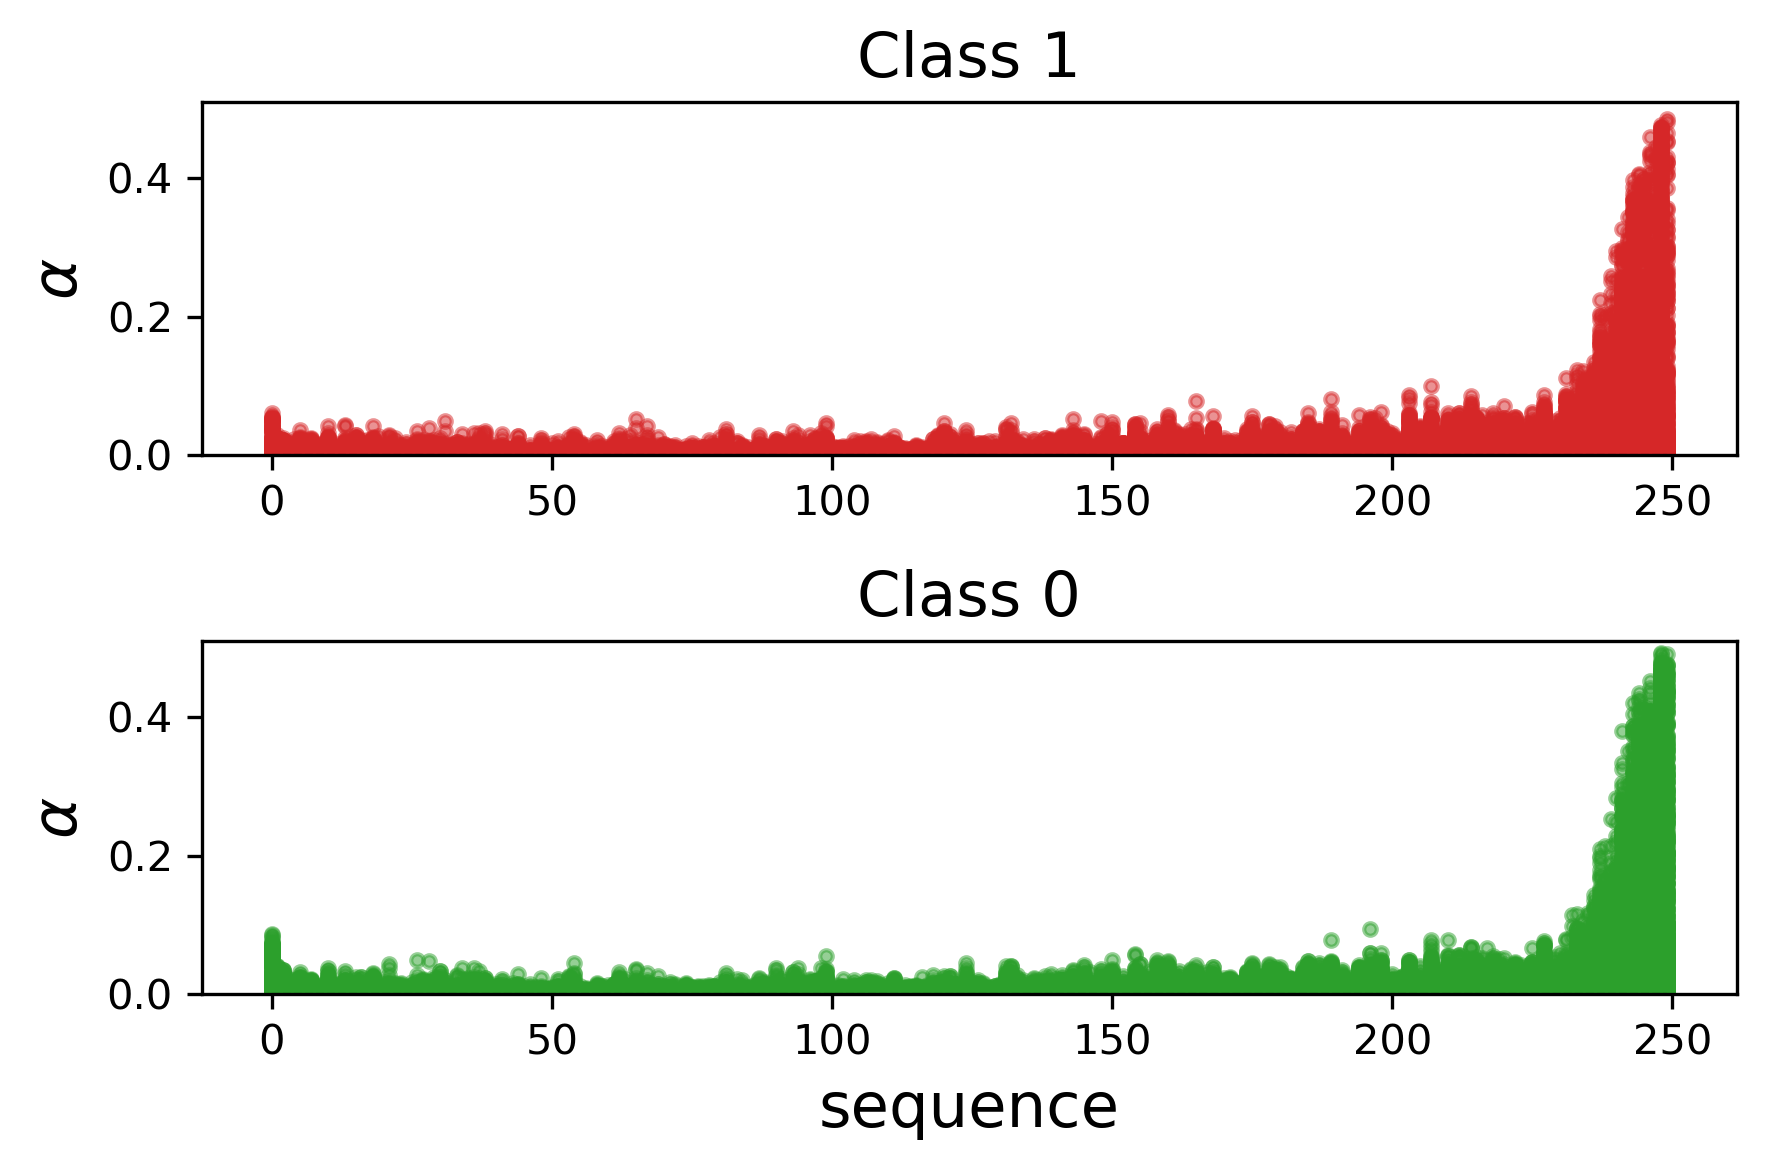

In [80]:
plot_attention(avg_alpha, np.arange(avg_alpha.shape[1]), "alpha", [0, 0.51]);
plt.savefig('figures/alphas_k={}.png'.format(cvk))
plt.savefig('figures/alphas_k={}.tiff'.format(cvk))

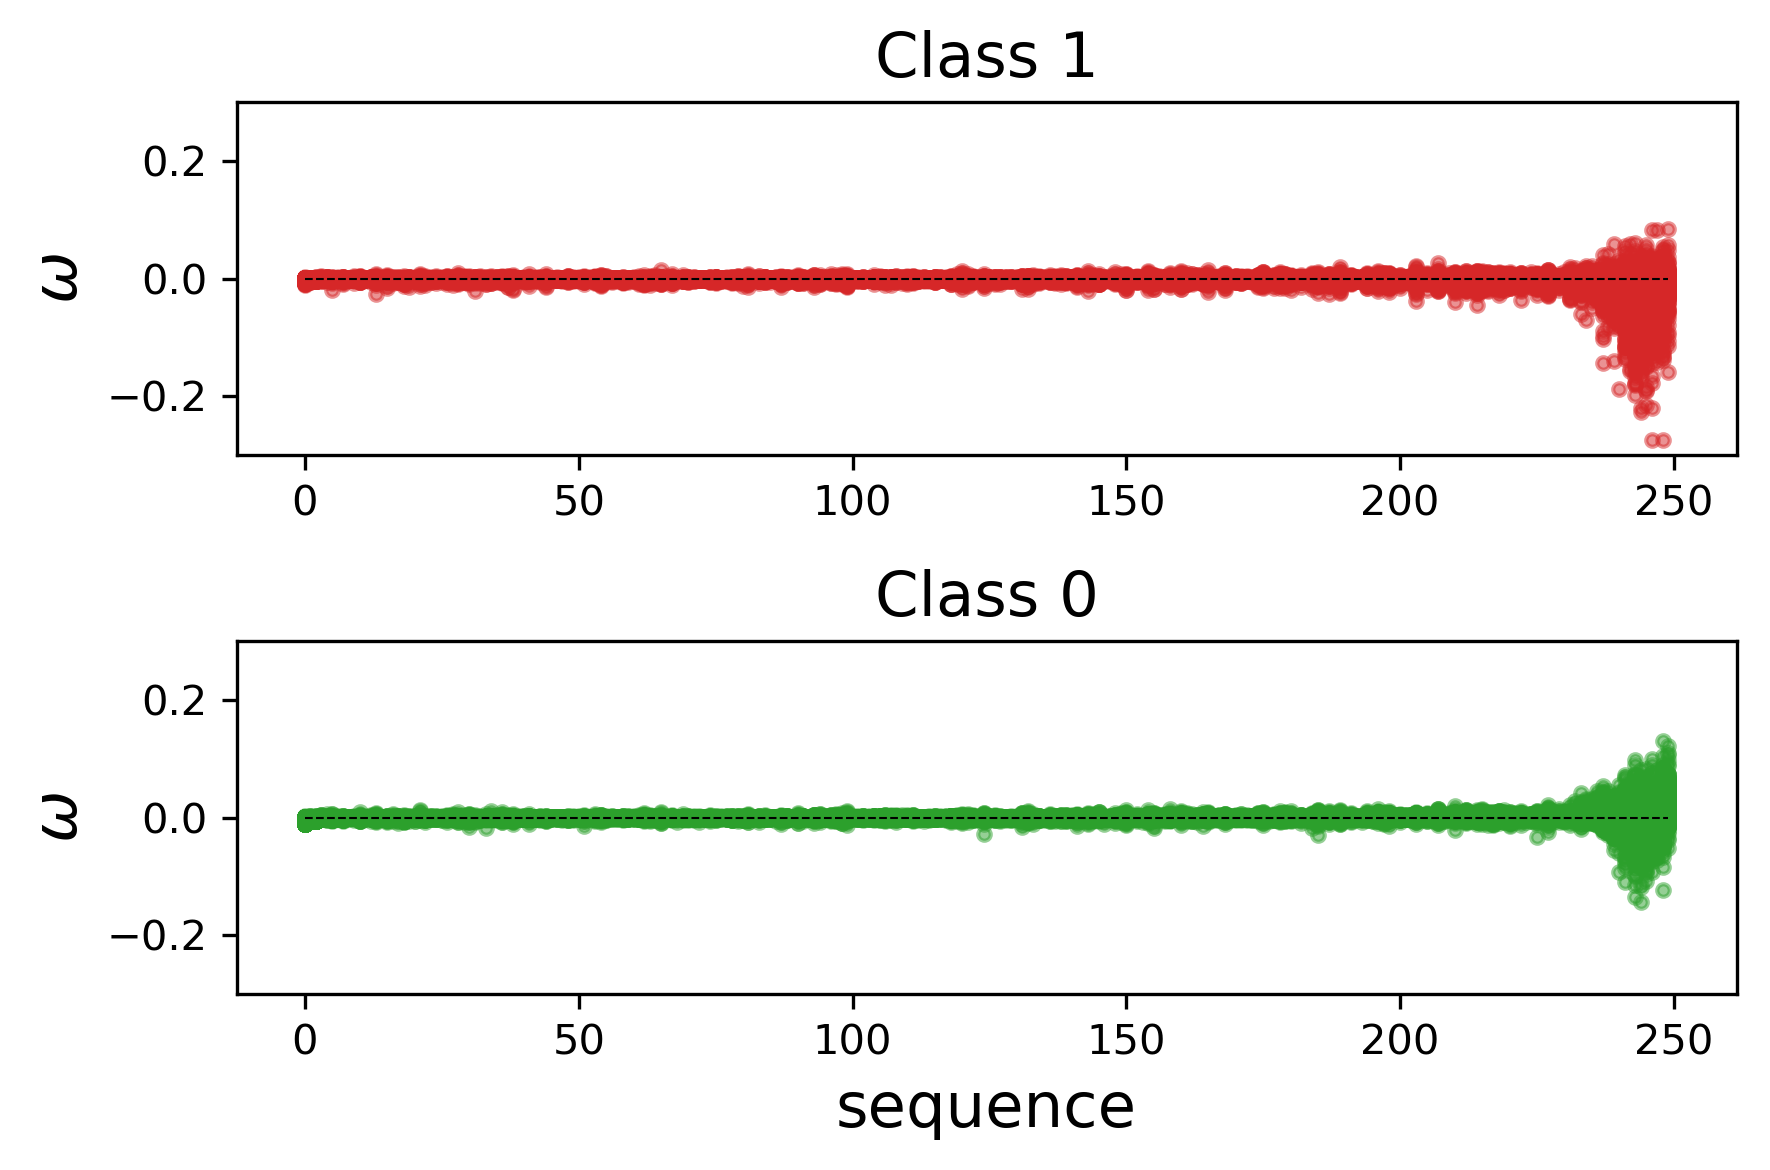

In [81]:
plot_attention(avg_omega, np.arange(avg_omega.shape[1]), 'omega', [-0.3, 0.3]);
plt.savefig('figures/omegas_k={}.png'.format(cvk))
plt.savefig('figures/omegas_k={}.tiff'.format(cvk))

Single attention:

In [13]:
# Build an inverse word map
word_map = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}
word_map[0] = 0

In [14]:
def attention_viz(i, alpha, omega):
    # Load the mbs sequence from the dataset
    tokenized_seq = D[0][0][i]
    mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
    
    # Retrieve the corresponding attention vector
    attention = alpha[i].squeeze()
    weights = omega[i].squeeze()
    
    # Filter out small attentions
    _idx = np.where(np.abs(attention) >= np.percentile(np.abs(attention), 75))[0]
    axis = np.arange(len(_idx))
    
    plt.figure(dpi=100, figsize=(20, 12))
    plt.subplot(211)
    plt.bar(axis, attention[_idx], color='C2')
    plt.xticks(axis, mbs_seq[_idx], rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Subj id: {} [class {}]'.format(i, D[1][i]), fontsize=15)
    plt.ylabel(r'$\alpha$', fontsize=15)
    
    plt.subplot(212)
    plt.bar(axis, weights[_idx], color='C3')
    plt.xticks(axis, mbs_seq[_idx], rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Subj id: {} [class {}]'.format(i, D[1][i]), fontsize=15)
    plt.ylabel(r'$\omega$', fontsize=15)
    
    plt.tight_layout()
    
    return plt

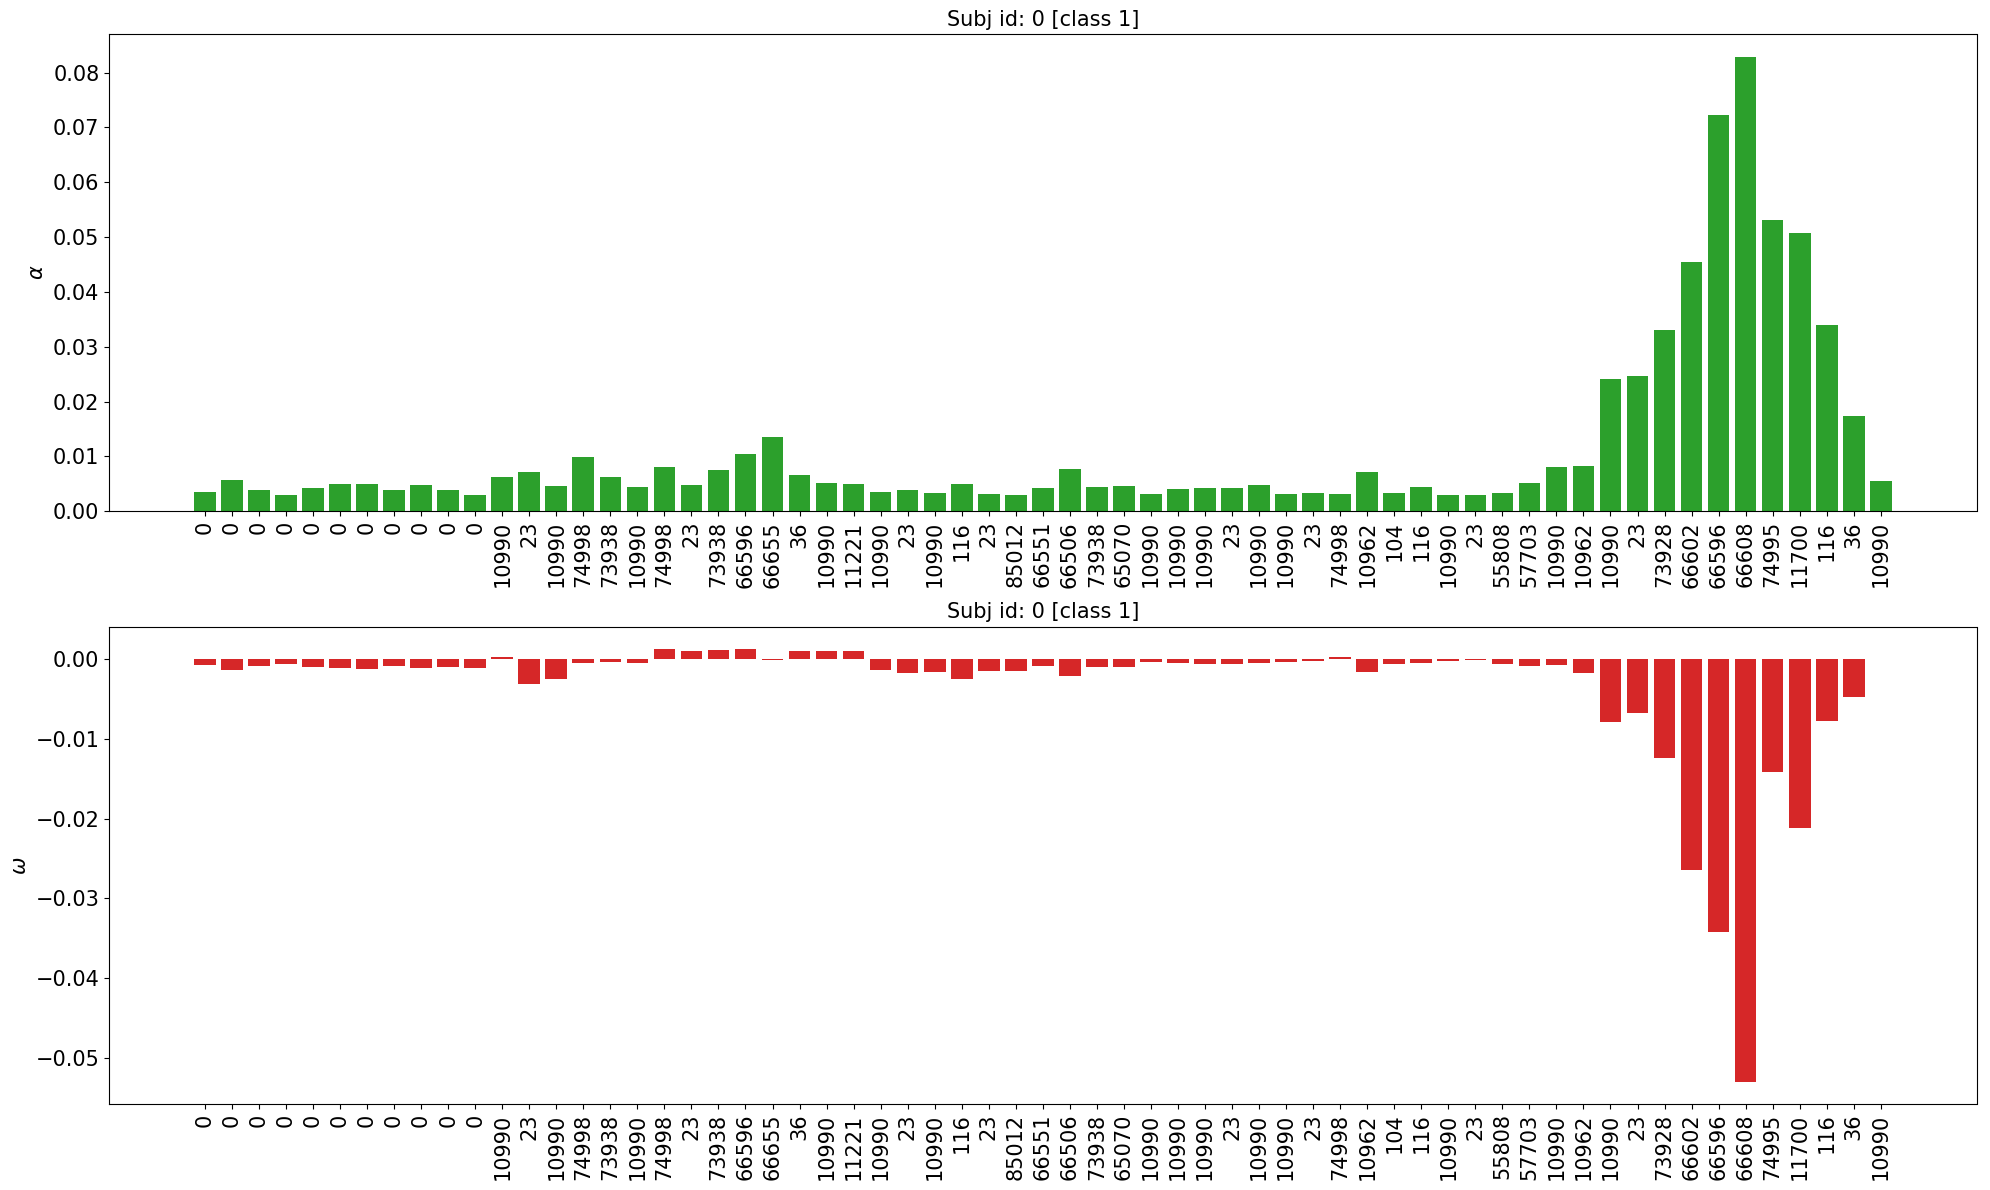

In [15]:
i = pos[0]
attention_viz(i, avg_alpha, avg_omega)
plt.savefig('figures/alpha_omega_subj{}_k={}.png'.format(i, cvk))

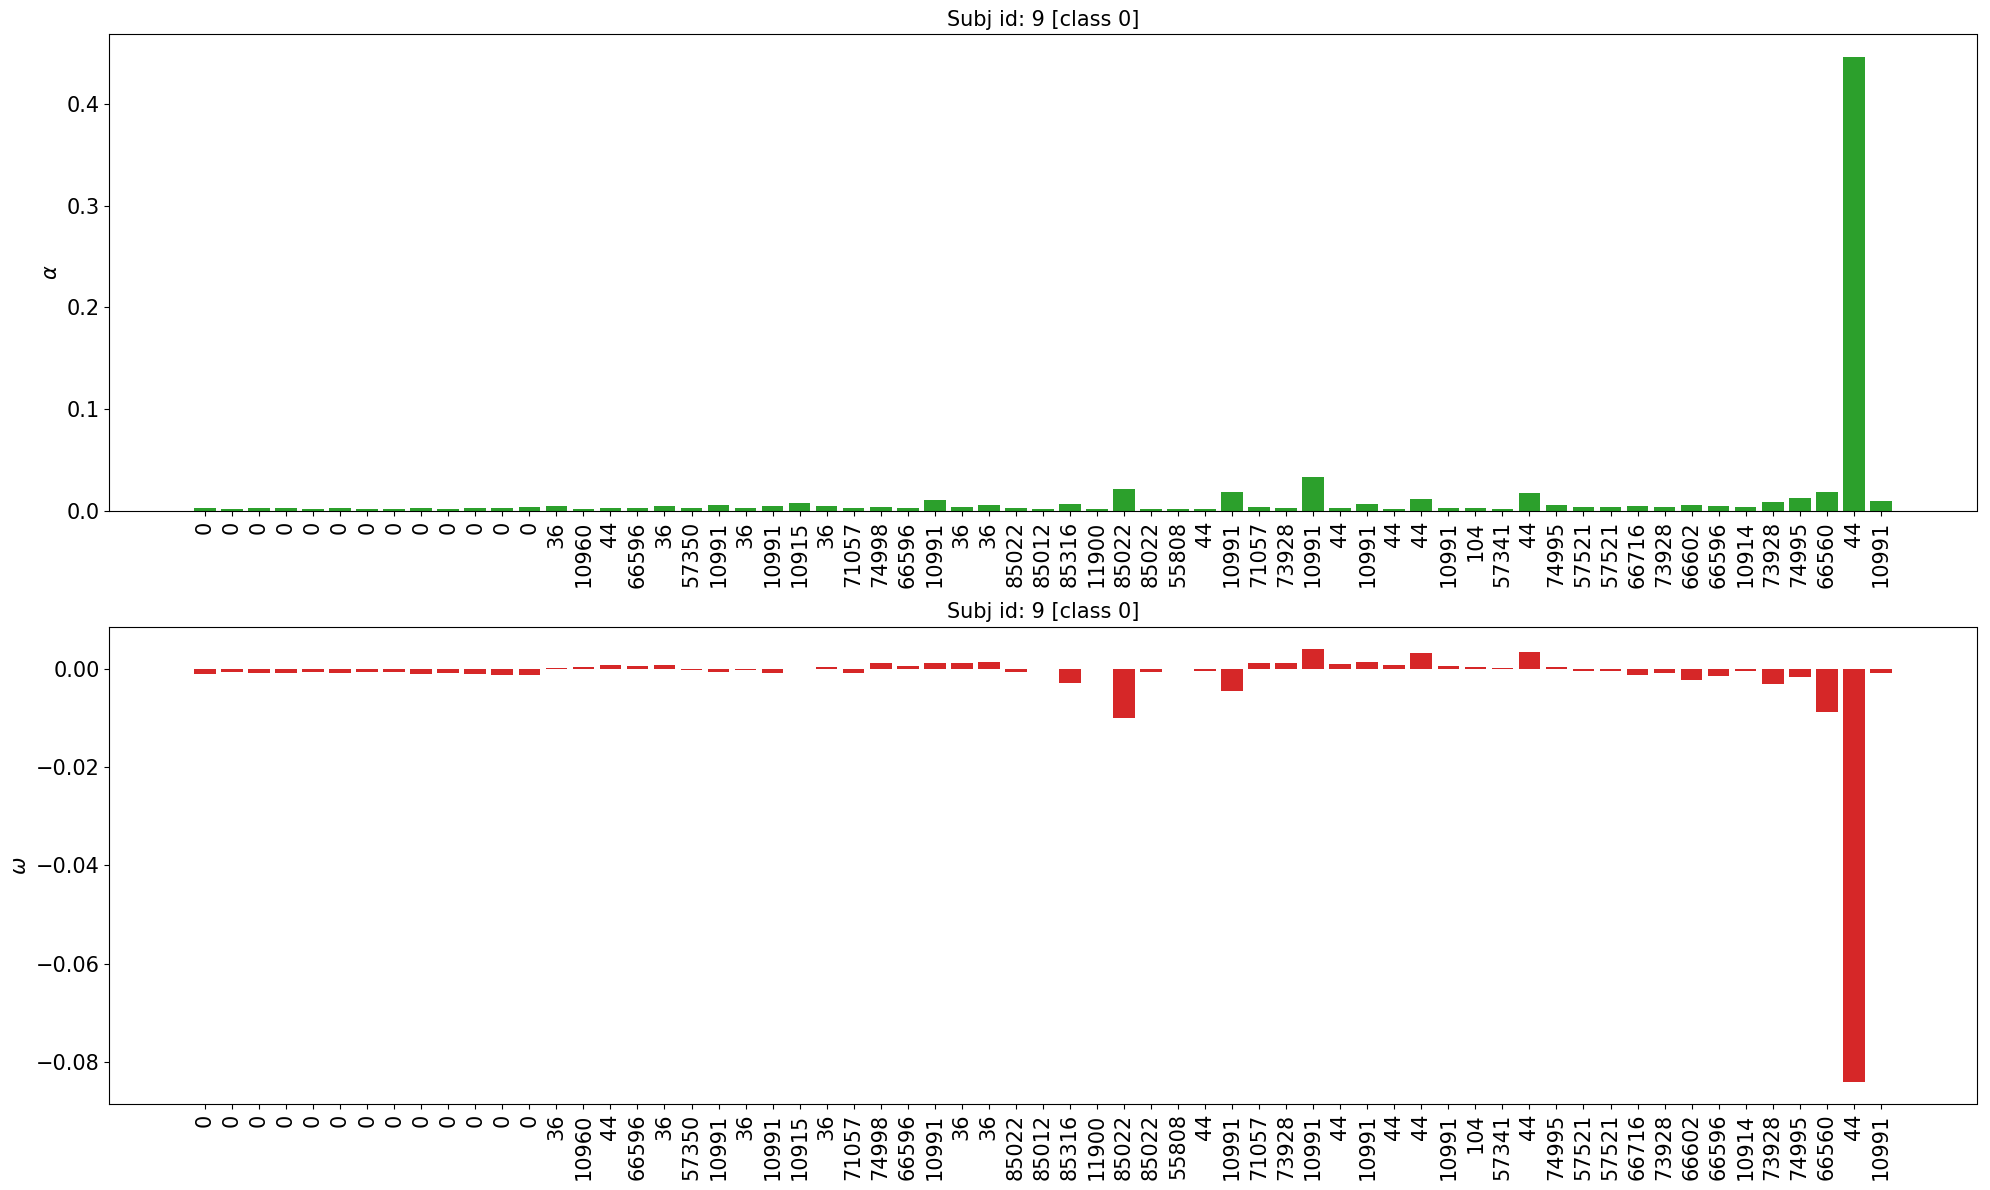

In [16]:
i = neg[3]
attention_viz(i, avg_alpha, avg_omega)
plt.savefig('figures/alpha_omega_subj{}_k={}.png'.format(i, cvk))

## Which MBS items get more attention?

In [17]:
from tqdm import tqdm, trange

def get_MBS_attention(c):
    # Save absolute value of attention level for each MBS item
    attention_dict = {}
    for i in trange(D[0][0].shape[0]):
        # Load the mbs sequence from the dataset
        tokenized_seq = D[0][0][i]
        mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
        
        # Retrieve the corresponding attention vector
        attention = np.abs(c[i].squeeze())
        
        # Keep nonzero only
        nz = np.where(mbs_seq != '0')[0]
        mbs_seq, attention = mbs_seq[nz], attention[nz]
        
        # Keep only the TOP 5%
        top_idx = np.where(attention >= np.percentile(attention, 75))[0]
        mbs_seq, attention = mbs_seq[top_idx], attention[top_idx]

        # Update the dict
        for item, att in zip(mbs_seq, attention):
            if item in attention_dict:
                attention_dict[item].append(att)
            else:
                attention_dict[item] = [att]
    
    return attention_dict

attention = get_MBS_attention(avg_alpha)
print(len(attention.keys()))

100%|██████████| 4698/4698 [00:02<00:00, 1739.28it/s]

1308


In [18]:
lenghts = [len(attention[k]) for k in attention.keys()]
np.percentile(lenghts, 50)

4.0

In [19]:
K = 100
filtered_attention = {}
for k in attention.keys():
    curr_att = np.array(attention[k])
    if len(curr_att) >= K:
        idx = np.arange(K)
        np.random.shuffle(idx)
        filtered_attention[k] = curr_att[idx]
print(len(filtered_attention.keys()))

116


In [20]:
item_map = pd.read_csv('../../tangle/data/item_map.tsv', sep='\t', header=0, index_col=0,
                      usecols=['ITEM', 'Mapped_Item_Desc', 'CATEGORY_DESC'])
item_map.loc[0, :] = ['', '']
item_map.head()

,Mapped_Item_Desc,CATEGORY_DESC
ITEM,,
1,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
2,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
3,Professional attendance at consulting rooms (n...,PROFESSIONAL ATTENDANCES
4,Consultation at a place other than consulting ...,PROFESSIONAL ATTENDANCES
5,Professional attendance at consulting rooms of...,PROFESSIONAL ATTENDANCES


In [21]:
avg_attention = {k: np.sum(filtered_attention[k]) for k in filtered_attention.keys()}
dfa = pd.DataFrame(data=avg_attention.values(), index=avg_attention.keys(), columns=['Attention_overall'])
dfa['Mapped_Item_Desc'] = [item_map.loc[i, 'Mapped_Item_Desc'] for i in map(int, dfa.index)]
dfa['CATEGORY_DESC'] = [item_map.loc[i, 'CATEGORY_DESC'] for i in map(int, dfa.index)]

In [22]:
dfa.nlargest(25, columns='Attention_overall')

,Attention_overall,Mapped_Item_Desc,CATEGORY_DESC
597,3.099906,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
5040,3.023440,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
10918,2.821402,"Professional attendance, being the second or s...",PROFESSIONAL ATTENDANCES
10914,2.807340,Professional attendance of more than 15 minute...,PROFESSIONAL ATTENDANCES
66560,2.806529,Microalbumin - quantitation in urine,PATHOLOGY SERVICES
30192,2.724945,Premalignant skin lesions (including solar ker...,THERAPEUTIC PROCEDURES
37,2.671698,Professional attendance by a general practitio...,PROFESSIONAL ATTENDANCES
66512,2.545147,5 or more tests described in item 66500,PATHOLOGY SERVICES
10900,2.512198,Professional attendance of more than 15 minute...,PROFESSIONAL ATTENDANCES
302,2.482774,Professional attendance by a consultant physic...,PROFESSIONAL ATTENDANCES


In [23]:
item = 66551
dfa.loc[str(item)]['Mapped_Item_Desc']

'Quantitation of glycated haemoglobin performed in the management of established diabetes \xe2\x80\x93 (item is subject to rule 25)'

# Embedding viz

In [24]:
X = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='pooling')[0]

----- activations -----
(4698, 50)


In [25]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import joblib as jl

# X_r = PCA(n_components=3).fit_transform(X)
# X_r = TSNE(n_components=3, init='pca').fit_transform(X)
X_r = jl.load('tsne_k={}.pkl'.format(cvk))

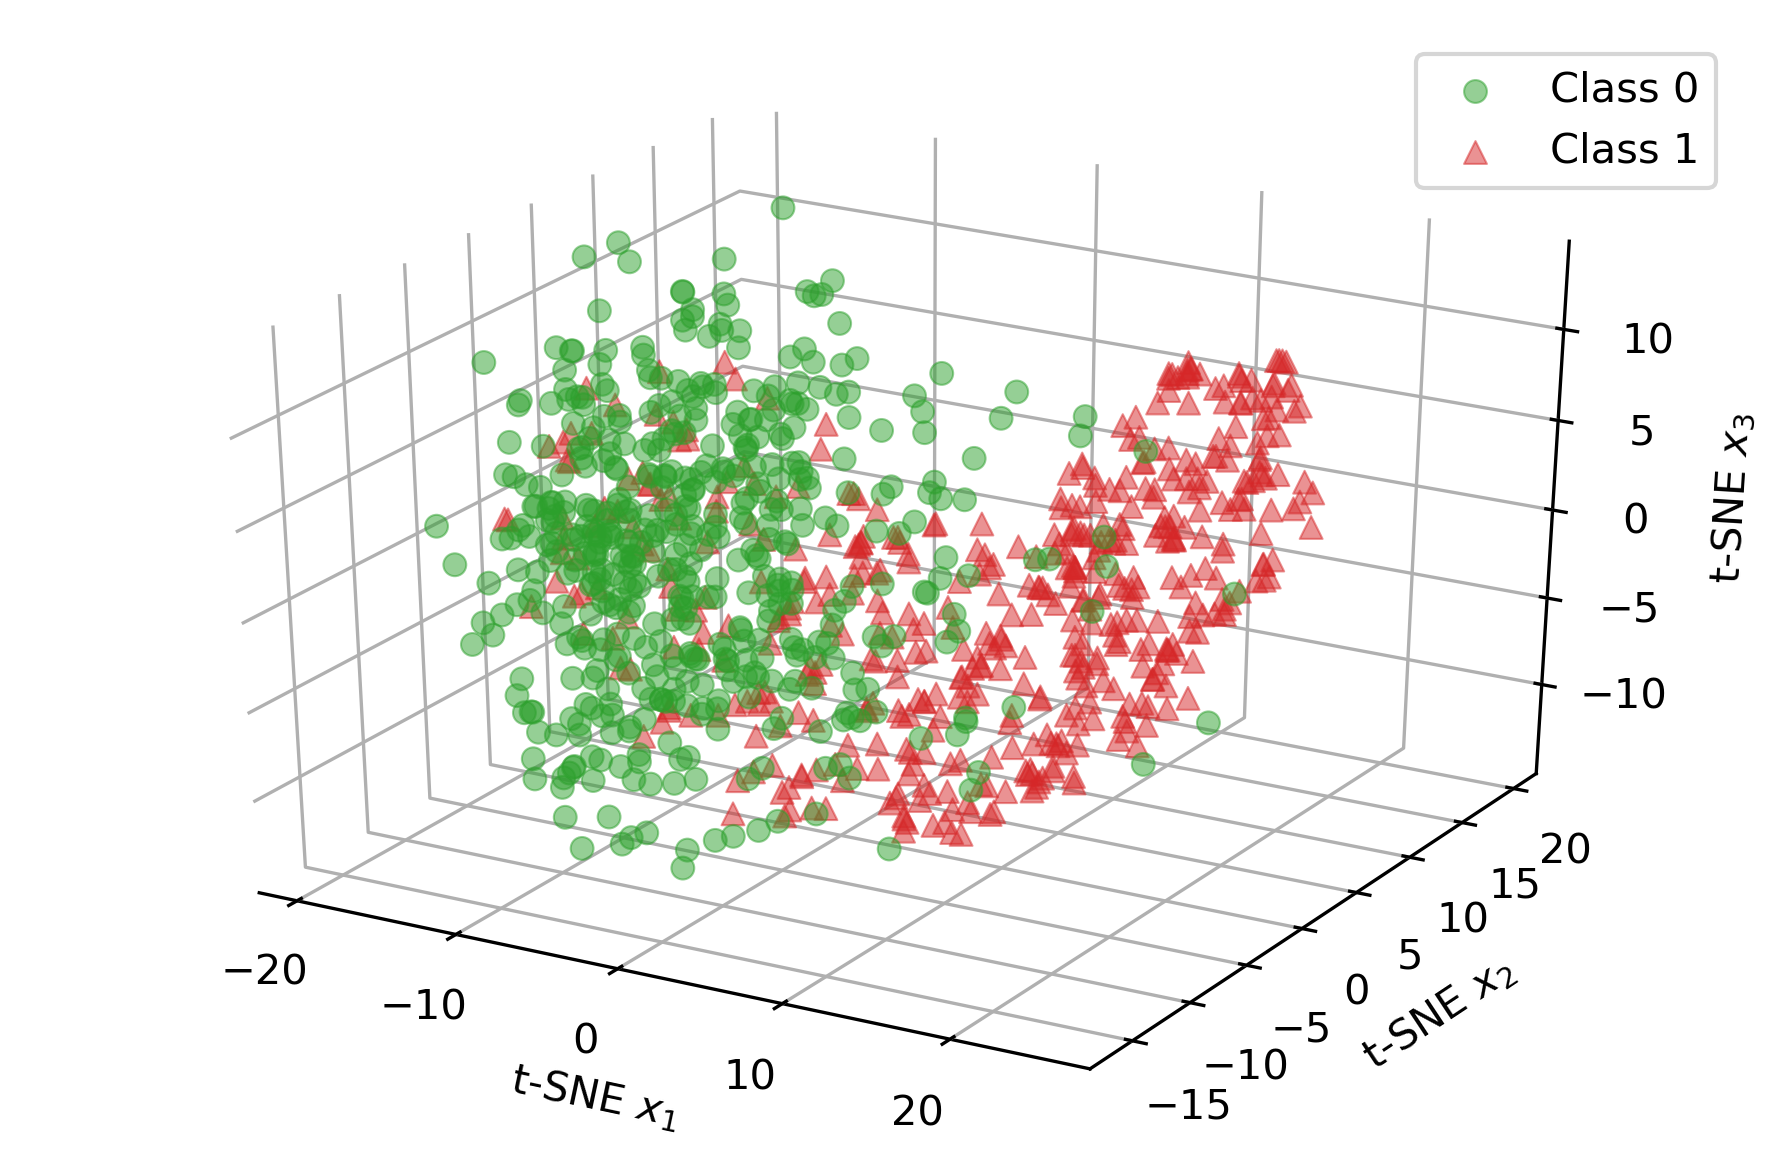

In [76]:
MAX = 500

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_r[neg[:MAX], 0], X_r[neg[:MAX], 1], X_r[pos[:MAX], 2],
           c='C2', label='Class 0', marker='o', linewidths=0.5, alpha=0.5, s=30)
ax.scatter(X_r[pos[:MAX], 0], X_r[pos[:MAX], 1], X_r[pos[:MAX], 2],
           c='C3', label='Class 1', marker='^', linewidths=0.5, alpha=0.5, s=30)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

ax.set_xlabel(r't-SNE $x_1$')
ax.set_ylabel(r't-SNE $x_2$')
ax.set_zlabel(r't-SNE $x_3$')
plt.legend()
plt.tight_layout()
plt.savefig('figures/tsne_k={}.png'.format(cvk));
plt.savefig('figures/tsne_k={}.tiff'.format(cvk));

In [27]:
# jl.dump(X_r, 'tsne_k={}.pkl'.format(cvk))